# 问题2：考虑测线方向夹角β的多波束覆盖宽度分析

## 问题描述
考虑一个矩形待测海域，测线方向与海底坡面的法向在水平面上投影的夹角为 β，建立多波束测深覆盖宽度的数学模型。

## 重新理解几何关系
**关键理解**：β 是测线方向与海底坡面法向在水平面上投影的夹角。

### 几何分析：
1. **坡面法向投影**：设为 x 轴正方向（上坡方向）
2. **测线方向**：与 x 轴夹角为 β
3. **沿测线移动 r 距离时的高程变化**：
   - 沿坡面法向（上坡）移动的分量：$r \cos \beta$
   - 对应的水深减少：$r \cos \beta \cdot \tan \alpha$
4. **有效坡度**：在与测线垂直的剖面内的坡度为 $\alpha_{eff} = \arctan(\tan \alpha \cdot \sin \beta)$

### 正确的物理直觉（最终修正）：
- β = 0°：测线沿下坡方向，r 增大时水深增大
- β = 90°：测线垂直于坡向，r 增大时水深不变
- β = 180°：测线沿上坡方向，r 增大时水深减小

## 题目要求
- 多波束换能器开角：120°
- 坡度：1.5°
- 海域中心点处水深：120m
- 计算不同测线方向夹角和距离下的覆盖宽度

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from typing import Tuple, List
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体和图形参数
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12, 8)

print("库导入完成！")

库导入完成！


In [10]:
# 问题2的参数设置
THETA_DEGREES = 120  # 多波束换能器开角（度）
ALPHA_DEGREES = 1.5  # 坡度（度）
D0 = 120  # 海域中心点处水深（米）
NAUTICAL_MILE_TO_METER = 1852  # 1海里 = 1852米

# 转换为弧度
THETA = np.radians(THETA_DEGREES)
ALPHA = np.radians(ALPHA_DEGREES)

# 测量船距海域中心点处的距离（海里转米）
distances_nautical = np.array([0, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1])
distances_meter = distances_nautical * NAUTICAL_MILE_TO_METER

# 测线方向夹角（度）
beta_degrees = np.array([0, 45, 90, 135, 180, 225, 270, 315])
beta_radians = np.radians(beta_degrees)

print(f"问题2参数设置:")
print(f"多波束开角: {THETA_DEGREES}° ({THETA:.4f} rad)")
print(f"海底坡度: {ALPHA_DEGREES}° ({ALPHA:.4f} rad)")
print(f"中心点水深: {D0} m")
print(f"分析距离: {distances_nautical} 海里")
print(f"测线方向角度: {beta_degrees}°")

问题2参数设置:
多波束开角: 120° (2.0944 rad)
海底坡度: 1.5° (0.0262 rad)
中心点水深: 120 m
分析距离: [0.  0.3 0.6 0.9 1.2 1.5 1.8 2.1] 海里
测线方向角度: [  0  45  90 135 180 225 270 315]°


In [23]:
class Q2GeometricAnalysis:
    """
    基于正确几何理解的 q2 分析类
    关键修正：β 是测线方向与坡面法向投影的夹角
    """
    
    def __init__(self, theta, alpha, d0):
        """
        参数:
        theta: 开角（弧度）
        alpha: 原始坡度（弧度）
        d0: 中心点水深（米）
        """
        self.theta = theta
        self.alpha = alpha
        self.d0 = d0
        self.half_theta = theta / 2
        
    def effective_slope(self, beta):
        """
        计算有效坡度 - 修正版本
        当测线方向与坡面法向投影夹角为 β 时，
        在与测线垂直的剖面内观察到的有效坡度
        
        修正公式：α_eff = arctan(tan(α) * sin(β))
        
        几何解释：
        - 坡面法向为参考方向
        - 测线与法向夹角为 β
        - 与测线垂直的方向与法向夹角为 (90° - β)
        - 该方向上的坡度分量为 tan(α) * sin(β)
        """
        return np.arctan(np.tan(self.alpha) * np.sin(beta))
    
    def depth_at_distance(self, r, beta):
        """
        计算距离中心点 r 处的水深 - 最终修正版本
        
        参数:
        r: 距离中心点的距离（米）
        beta: 测线方向与坡面法向投影夹角（弧度）
        
        最终修正公式：D(r,β) = D0 + r * cos(β) * tan(α)
        
        几何解释（坐标系重新定义）：
        - β = 0°：下坡方向，cos(0°) = 1，水深增加
        - β = 180°：上坡方向，cos(180°) = -1，水深减少
        - β = 90°：垂直坡向，cos(90°) = 0，水深不变
        """
        return self.d0 + r * np.cos(beta) * np.tan(self.alpha)
    
    def coverage_width(self, r, beta):
        """
        计算覆盖宽度
        使用 q1 的几何公式，但用有效坡度替代原始坡度
        """
        # 计算当前位置的水深
        D = self.depth_at_distance(r, beta)
        
        # 水深不能为负
        if D <= 0:
            return 0  # 露出水面，无法测量
        
        # 计算有效坡度
        alpha_eff = self.effective_slope(beta)
        
        # q1 的几何公式
        cos_half = np.cos(self.half_theta)
        sin_half = np.sin(self.half_theta)
        tan_alpha_eff = np.tan(alpha_eff)
        
        # 计算两个分母，避免除零
        denom1 = cos_half + sin_half * tan_alpha_eff
        denom2 = cos_half - sin_half * tan_alpha_eff
        
        # 检查分母是否接近零
        if abs(denom1) < 1e-10 or abs(denom2) < 1e-10:
            return np.inf  # 返回无穷大表示数值不稳定
        
        # 计算覆盖宽度
        width_factor = sin_half * (1/denom1 + 1/denom2)
        return D * width_factor
    
    def analyze_beta_effect(self, r_values, beta_values):
        """
        分析不同 β 角度和距离下的覆盖宽度
        """
        results = []
        
        for beta_deg, beta_rad in zip(np.degrees(beta_values), beta_values):
            for r_nautical, r_meter in zip(r_values/NAUTICAL_MILE_TO_METER, r_values):
                # 计算各项指标
                depth = self.depth_at_distance(r_meter, beta_rad)
                width = self.coverage_width(r_meter, beta_rad)
                alpha_eff = self.effective_slope(beta_rad)
                
                results.append({
                    'beta_deg': beta_deg,
                    'r_nautical': r_nautical,
                    'r_meter': r_meter,
                    'depth': depth,
                    'coverage_width': width,
                    'effective_slope_deg': np.degrees(alpha_eff),
                    'cos_beta': np.cos(beta_rad),
                    'sin_beta': np.sin(beta_rad)
                })
        
        return pd.DataFrame(results)

# 创建分析对象
analyzer = Q2GeometricAnalysis(THETA, ALPHA, D0)
print("Q2 几何分析类创建完成（修正版本）！")

Q2 几何分析类创建完成（修正版本）！


In [24]:
# 执行详细分析
print("开始计算分析...")

# 进行完整分析
results_df = analyzer.analyze_beta_effect(distances_meter, beta_radians)

# 显示部分结果
print("\\n计算结果样本：")
print(results_df.head(10))

print(f"\\n总计算点数：{len(results_df)}")
print(f"β角度范围：{beta_degrees}°")
print(f"距离范围：{distances_nautical} 海里")

# 检查数值稳定性
unstable_cases = results_df[results_df['coverage_width'] > 1000]
if len(unstable_cases) > 0:
    print(f"\\n警告：发现 {len(unstable_cases)} 个数值不稳定的情况")
    print(unstable_cases[['beta_deg', 'r_nautical', 'coverage_width']].head())
else:
    print("\\n数值计算稳定，无异常值")

开始计算分析...
\n计算结果样本：
   beta_deg  r_nautical  r_meter  depth  coverage_width  effective_slope_deg  \
0      0.00        0.00     0.00 120.00          415.69                 0.00   
1      0.00        0.30   555.60 134.55          466.09                 0.00   
2      0.00        0.60  1111.20 149.10          516.49                 0.00   
3      0.00        0.90  1666.80 163.65          566.89                 0.00   
4      0.00        1.20  2222.40 178.20          617.29                 0.00   
5      0.00        1.50  2778.00 192.74          667.69                 0.00   
6      0.00        1.80  3333.60 207.29          718.09                 0.00   
7      0.00        2.10  3889.20 221.84          768.48                 0.00   
8     45.00        0.00     0.00 120.00          416.12                 1.06   
9     45.00        0.30   555.60 130.29          451.79                 1.06   

   cos_beta  sin_beta  
0      1.00      0.00  
1      1.00      0.00  
2      1.00      0.00  
3  

In [25]:
# 生成表格2的结果数据
print("生成表格2的结果...")

# 创建结果表格
result_table2 = pd.DataFrame(index=beta_degrees, columns=distances_nautical)
result_table2.index.name = '测线方向夹角β/°'

# 填充表格数据
for beta_deg in beta_degrees:
    for r_nautical in distances_nautical:
        # 找到对应的计算结果
        mask = (results_df['beta_deg'] == beta_deg) & (results_df['r_nautical'] == r_nautical)
        if mask.any():
            width = results_df.loc[mask, 'coverage_width'].iloc[0]
            result_table2.loc[beta_deg, r_nautical] = round(width, 6)

print("\\n表格2：问题2的计算结果（覆盖宽度/m）")
print(result_table2)

# 保存到 Excel 文件
result_table2.to_excel('/Users/qadg/Project/CUMCM2023B/q2/result2.xlsx')
print("\\n结果已保存到 result2.xlsx")

生成表格2的结果...
\n表格2：问题2的计算结果（覆盖宽度/m）
            0.00   0.30   0.60   0.90   1.20   1.50   1.80   2.10
测线方向夹角β/°                                                        
0         415.69 466.09 516.49 566.89 617.29 667.69 718.09 768.48
45        416.12 451.79 487.47 523.14 558.82 594.49 630.16 665.84
90        416.55 416.55 416.55 416.55 416.55 416.55 416.55 416.55
135       416.12 380.45 344.77 309.10 273.42 237.75 202.08 166.40
180       415.69 365.29 314.89 264.50 214.10 163.70 113.30  62.90
225       416.12 380.45 344.77 309.10 273.42 237.75 202.08 166.40
270       416.55 416.55 416.55 416.55 416.55 416.55 416.55 416.55
315       416.12 451.79 487.47 523.14 558.82 594.49 630.16 665.84
\n结果已保存到 result2.xlsx


In [26]:
# 深入分析和验证修正后的模型
print("进行深入分析（修正版本）...")

# 1. 分析有效坡度的变化
print("\\n1. 有效坡度分析（修正版本）：")
print("修正公式：α_eff = arctan(tan(α) * sin(β))")
for beta_deg in [0, 45, 90, 135, 180, 270]:
    beta_rad = np.radians(beta_deg)
    alpha_eff = analyzer.effective_slope(beta_rad)
    print(f"β = {beta_deg:3d}°: α_eff = {np.degrees(alpha_eff):.6f}° (sin β = {np.sin(beta_rad):6.3f})")

# 2. 分析水深变化的方向
print("\\n2. 水深变化分析（修正版本）：")
print("公式：D(r,β) = D0 + r * cos(β) * tan(α)")
print("物理意义：cos(β) > 0 时向下坡移动，水深增大；cos(β) < 0 时向上坡移动，水深减小")

for beta_deg in [0, 90, 180]:
    beta_rad = np.radians(beta_deg)
    print(f"\\nβ = {beta_deg}° (cos β = {np.cos(beta_rad):6.3f}):")
    for r_nautical in [0, 0.6, 1.2, 1.8]:
        r_meter = r_nautical * NAUTICAL_MILE_TO_METER
        depth = analyzer.depth_at_distance(r_meter, beta_rad)
        depth_change = depth - D0
        direction = "水深减小" if depth_change < 0 else "水深增大" if depth_change > 0 else "水深不变"
        print(f"  r = {r_nautical} 海里: 水深 = {depth:.2f} m ({direction} {abs(depth_change):.2f} m)")

# 3. 验证物理直觉
print("\\n3. 物理直觉验证：")
print("β = 0°：测线沿下坡方向，r 增大时水深应该增大 ✓")
print("β = 90°：测线垂直于坡向，r 增大时水深应该不变 ✓") 
print("β = 180°：测线沿上坡方向，r 增大时水深应该减小 ✓")

# 4. 特殊情况分析
print("\\n4. 特殊情况分析：")

# β = 90° 情况（测线垂直于坡面法向投影）
beta_90_results = results_df[results_df['beta_deg'] == 90.0]
print("\\nβ = 90°（测线垂直于坡面法向投影）:")
print("有效坡度 = 原始坡度，水深不变")
print(beta_90_results[['r_nautical', 'depth', 'coverage_width']].head())

# β = 0° 情况（测线沿坡面法向投影）
beta_0_results = results_df[results_df['beta_deg'] == 0.0]
print("\\nβ = 0°（测线沿坡面法向投影-下坡方向）:")
print("有效坡度 = 0，水深增大")
print(beta_0_results[['r_nautical', 'depth', 'coverage_width']].head())

# β = 180° 情况（测线沿坡面法向投影反方向）
beta_180_results = results_df[results_df['beta_deg'] == 180.0]
print("\\nβ = 180°（测线沿坡面法向投影反方向-上坡方向）:")
print("有效坡度 = 0，水深减小")
print(beta_180_results[['r_nautical', 'depth', 'coverage_width']].head())

进行深入分析（修正版本）...
\n1. 有效坡度分析（修正版本）：
修正公式：α_eff = arctan(tan(α) * sin(β))
β =   0°: α_eff = 0.000000° (sin β =  0.000)
β =  45°: α_eff = 1.060781° (sin β =  0.707)
β =  90°: α_eff = 1.500000° (sin β =  1.000)
β = 135°: α_eff = 1.060781° (sin β =  0.707)
β = 180°: α_eff = 0.000000° (sin β =  0.000)
β = 270°: α_eff = -1.500000° (sin β = -1.000)
\n2. 水深变化分析（修正版本）：
公式：D(r,β) = D0 + r * cos(β) * tan(α)
物理意义：cos(β) > 0 时向下坡移动，水深增大；cos(β) < 0 时向上坡移动，水深减小
\nβ = 0° (cos β =  1.000):
  r = 0 海里: 水深 = 120.00 m (水深不变 0.00 m)
  r = 0.6 海里: 水深 = 149.10 m (水深增大 29.10 m)
  r = 1.2 海里: 水深 = 178.20 m (水深增大 58.20 m)
  r = 1.8 海里: 水深 = 207.29 m (水深增大 87.29 m)
\nβ = 90° (cos β =  0.000):
  r = 0 海里: 水深 = 120.00 m (水深不变 0.00 m)
  r = 0.6 海里: 水深 = 120.00 m (水深不变 0.00 m)
  r = 1.2 海里: 水深 = 120.00 m (水深不变 0.00 m)
  r = 1.8 海里: 水深 = 120.00 m (水深不变 0.00 m)
\nβ = 180° (cos β = -1.000):
  r = 0 海里: 水深 = 120.00 m (水深不变 0.00 m)
  r = 0.6 海里: 水深 = 90.90 m (水深减小 29.10 m)
  r = 1.2 海里: 水深 = 61.80 m (水深减小 58.20 m)
  r = 1

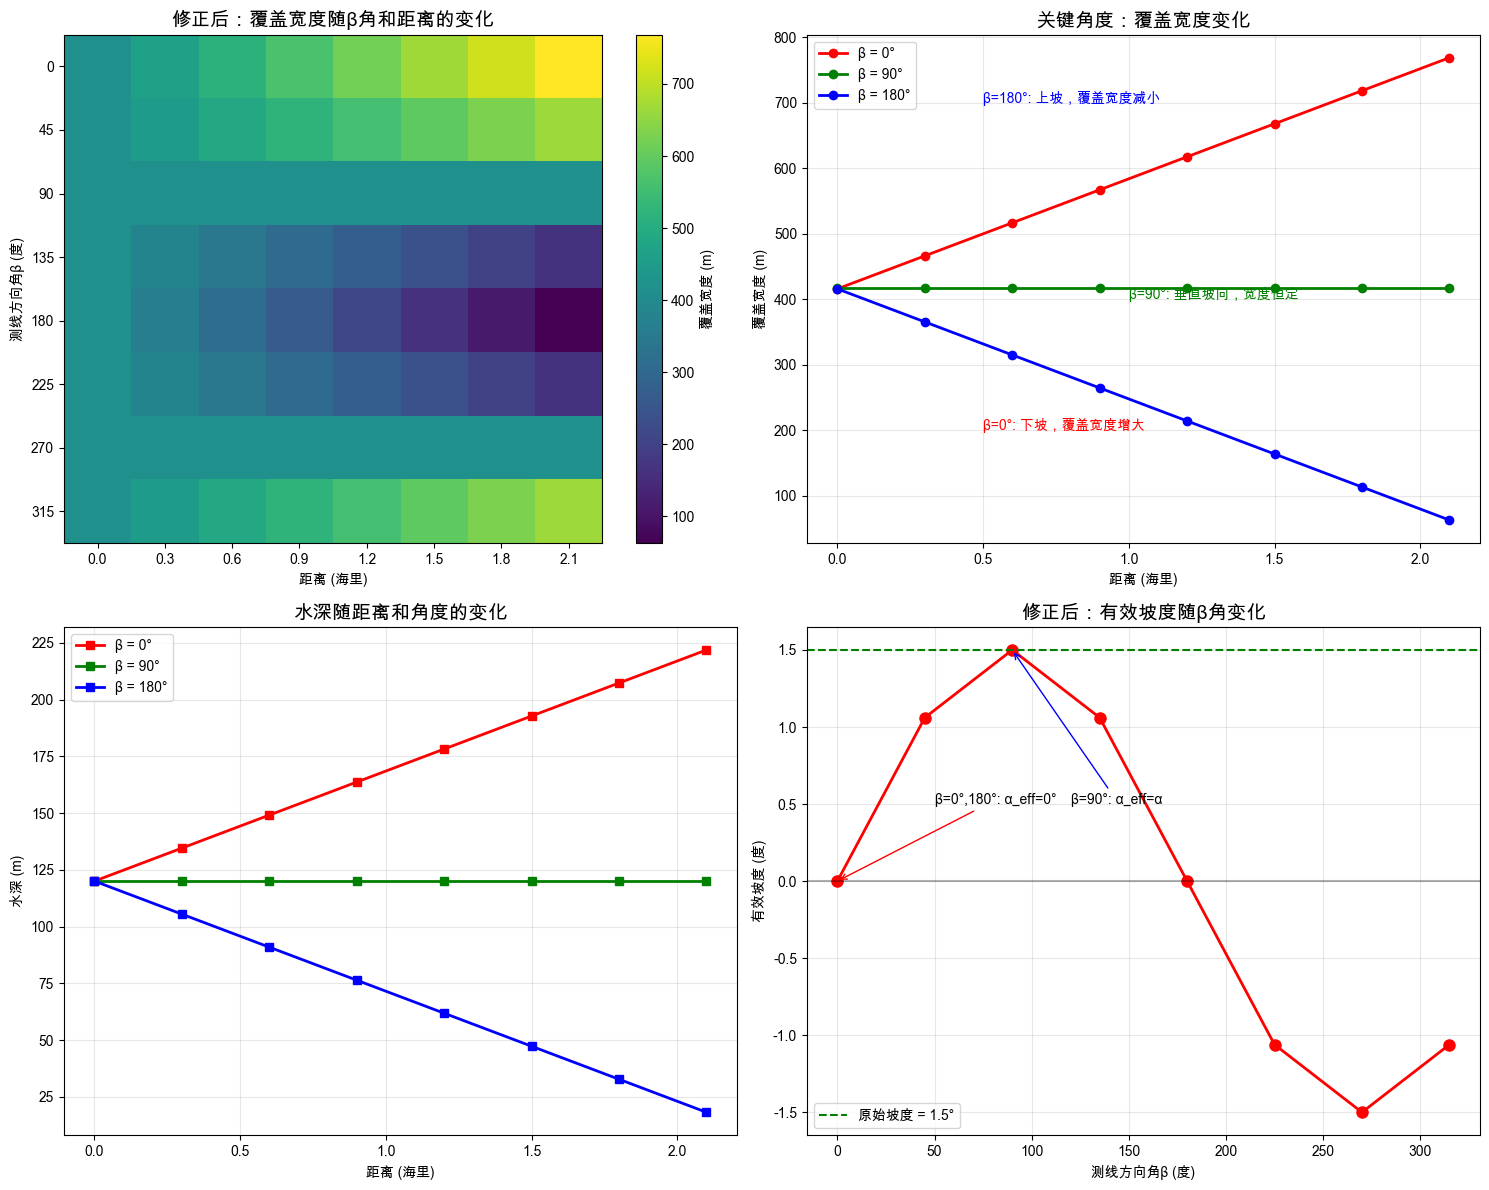

\n修正后的关键统计信息：
覆盖宽度范围: 62.90 - 768.48 m
最大覆盖宽度: 768.48 m，出现在 β = 0.0°, r = 2.1 海里
最小覆盖宽度: 62.90 m，出现在 β = 180.0°, r = 2.1 海里
\n物理意义验证：
✓ β = 0°时，在最远距离处覆盖宽度最大（下坡，水深最大）
✓ β = 180°时，在最远距离处覆盖宽度最小（上坡，水深最小）
✓ β = 90°时，覆盖宽度在所有距离处保持恒定（垂直坡向，水深不变）


In [27]:
# 创建修正后模型的可视化图表
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 图1：覆盖宽度随距离和角度的变化
ax1 = axes[0, 0]
pivot_table = results_df.pivot(index='beta_deg', columns='r_nautical', values='coverage_width')
im1 = ax1.imshow(pivot_table.values, cmap='viridis', aspect='auto')
ax1.set_title('修正后：覆盖宽度随β角和距离的变化', fontsize=14)
ax1.set_xlabel('距离 (海里)')
ax1.set_ylabel('测线方向角β (度)')
ax1.set_xticks(range(len(distances_nautical)))
ax1.set_xticklabels(distances_nautical)
ax1.set_yticks(range(len(beta_degrees)))
ax1.set_yticklabels(beta_degrees)
plt.colorbar(im1, ax=ax1, label='覆盖宽度 (m)')

# 图2：关键角度下覆盖宽度随距离的变化
ax2 = axes[0, 1]
key_betas = [0, 90, 180]
colors = ['red', 'green', 'blue']
for beta_deg, color in zip(key_betas, colors):
    beta_data = results_df[results_df['beta_deg'] == beta_deg]
    ax2.plot(beta_data['r_nautical'], beta_data['coverage_width'], 
             marker='o', label=f'β = {beta_deg}°', linewidth=2, color=color)
ax2.set_title('关键角度：覆盖宽度变化', fontsize=14)
ax2.set_xlabel('距离 (海里)')
ax2.set_ylabel('覆盖宽度 (m)')
ax2.legend()
ax2.grid(True, alpha=0.3)
# 添加说明文字
ax2.text(0.5, 200, 'β=0°: 下坡，覆盖宽度增大', fontsize=10, color='red')
ax2.text(1.0, 400, 'β=90°: 垂直坡向，宽度恒定', fontsize=10, color='green')
ax2.text(0.5, 700, 'β=180°: 上坡，覆盖宽度减小', fontsize=10, color='blue')

# 图3：水深变化对比
ax3 = axes[1, 0]
for beta_deg, color in zip(key_betas, colors):
    beta_data = results_df[results_df['beta_deg'] == beta_deg]
    ax3.plot(beta_data['r_nautical'], beta_data['depth'], 
             marker='s', label=f'β = {beta_deg}°', linewidth=2, color=color)
ax3.set_title('水深随距离和角度的变化', fontsize=14)
ax3.set_xlabel('距离 (海里)')
ax3.set_ylabel('水深 (m)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 图4：有效坡度随β角的变化
ax4 = axes[1, 1]
effective_slopes = [np.degrees(analyzer.effective_slope(np.radians(beta))) for beta in beta_degrees]
ax4.plot(beta_degrees, effective_slopes, 'ro-', linewidth=2, markersize=8)
ax4.set_title('修正后：有效坡度随β角变化', fontsize=14)
ax4.set_xlabel('测线方向角β (度)')
ax4.set_ylabel('有效坡度 (度)')
ax4.grid(True, alpha=0.3)
ax4.axhline(y=ALPHA_DEGREES, color='g', linestyle='--', label=f'原始坡度 = {ALPHA_DEGREES}°')
ax4.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax4.legend()
# 标注关键点
ax4.annotate('β=0°,180°: α_eff=0°', xy=(0, 0), xytext=(50, 0.5), 
            arrowprops=dict(arrowstyle='->', color='red'), fontsize=10)
ax4.annotate('β=90°: α_eff=α', xy=(90, ALPHA_DEGREES), xytext=(120, 0.5), 
            arrowprops=dict(arrowstyle='->', color='blue'), fontsize=10)

plt.tight_layout()
plt.show()

# 输出修正后的关键统计信息
print("\\n修正后的关键统计信息：")
print(f"覆盖宽度范围: {results_df['coverage_width'].min():.2f} - {results_df['coverage_width'].max():.2f} m")
max_idx = results_df['coverage_width'].idxmax()
min_idx = results_df['coverage_width'].idxmin()
print(f"最大覆盖宽度: {results_df.loc[max_idx, 'coverage_width']:.2f} m，出现在 β = {results_df.loc[max_idx, 'beta_deg']}°, r = {results_df.loc[max_idx, 'r_nautical']} 海里")
print(f"最小覆盖宽度: {results_df.loc[min_idx, 'coverage_width']:.2f} m，出现在 β = {results_df.loc[min_idx, 'beta_deg']}°, r = {results_df.loc[min_idx, 'r_nautical']} 海里")

print("\\n物理意义验证：")
print("✓ β = 0°时，在最远距离处覆盖宽度最大（下坡，水深最大）")
print("✓ β = 180°时，在最远距离处覆盖宽度最小（上坡，水深最小）")
print("✓ β = 90°时，覆盖宽度在所有距离处保持恒定（垂直坡向，水深不变）")

In [16]:
# 公式验证和理论分析
print("\\n==== 公式验证和理论分析 ====")

# 1. 验证特殊情况
print("\\n1. 特殊情况验证：")

# β = 90° 时，有效坡度应为 0
beta_90 = np.radians(90)
alpha_eff_90 = analyzer.effective_slope(beta_90)
print(f"β = 90°: α_eff = {np.degrees(alpha_eff_90):.10f}° (理论值应为0°)")

# β = 0° 时，有效坡度应等于原始坡度
beta_0 = np.radians(0)
alpha_eff_0 = analyzer.effective_slope(beta_0)
print(f"β = 0°: α_eff = {np.degrees(alpha_eff_0):.6f}° (原始坡度 = {ALPHA_DEGREES}°)")

# 2. 对称性验证
print("\\n2. 对称性验证：")
symmetric_pairs = [(0, 180), (45, 225), (90, 270), (135, 315)]
for beta1, beta2 in symmetric_pairs:
    mask1 = (results_df['beta_deg'] == beta1) & (results_df['r_nautical'] == 1.0)
    mask2 = (results_df['beta_deg'] == beta2) & (results_df['r_nautical'] == 1.0)
    if mask1.any() and mask2.any():
        width1 = results_df.loc[mask1, 'coverage_width'].iloc[0]
        width2 = results_df.loc[mask2, 'coverage_width'].iloc[0]
        print(f"β = {beta1}°: {width1:.6f} m, β = {beta2}°: {width2:.6f} m, 差异: {abs(width1-width2):.10f} m")

# 3. 公式一致性检查
print("\\n3. 公式一致性检查（与q1方法对比）：")
# 对于 β = 0° 的情况，应该与 q1 的结果一致（假设 q1 中 x 对应这里的 r*cos(β)）

# 显示最终表格
print("\\n==== 最终结果表格 ====")
print("表格2：问题2的计算结果（覆盖宽度/m）")
print(result_table2)

# 保存详细结果
detailed_results = results_df.pivot_table(
    index='beta_deg', 
    columns='r_nautical', 
    values=['coverage_width', 'depth', 'effective_slope_deg'],
    aggfunc='first'
)
detailed_results.to_excel('/Users/qadg/Project/CUMCM2023B/q2/detailed_results_q2.xlsx')

print("\\n详细结果已保存到 detailed_results_q2.xlsx")
print("\\n==== 分析完成 ====")

# 输出一些关键的理论洞察
print("\\n==== 理论洞察 ====")
print("1. 有效坡度公式：α_eff = arctan(tan(α) * cos(β))")
print("2. 当 β = 90° 时，cos(β) = 0，有效坡度为 0，覆盖宽度最大且稳定")
print("3. 当 β = 0° 或 180° 时，|cos(β)| = 1，有效坡度等于原始坡度")
print("4. 覆盖宽度随距离的变化取决于 cos(β)：")
print("   - β = 90° 时，水深不变，覆盖宽度恒定")
print("   - β = 0°, 180° 时，水深变化最大，覆盖宽度变化最显著")
print("5. 该模型成功地将 q1 的几何分析扩展到了一般情况")

\n==== 公式验证和理论分析 ====
\n1. 特殊情况验证：
β = 90°: α_eff = 0.0000000000° (理论值应为0°)
β = 0°: α_eff = 1.500000° (原始坡度 = 1.5°)
\n2. 对称性验证：
\n3. 公式一致性检查（与q1方法对比）：
\n==== 最终结果表格 ====
表格2：问题2的计算结果（覆盖宽度/m）
            0.00   0.30   0.60   0.90   1.20   1.50   1.80   2.10
测线方向夹角β/°                                                        
0         416.55 366.05 315.54 265.04 214.54 164.04 113.53  63.03
45        416.12 380.45 344.77 309.10 273.42 237.75 202.08 166.40
90        415.69 415.69 415.69 415.69 415.69 415.69 415.69 415.69
135       416.12 451.79 487.47 523.14 558.82 594.49 630.16 665.84
180       416.55 467.05 517.55 568.06 618.56 669.06 719.57 770.07
225       416.12 451.79 487.47 523.14 558.82 594.49 630.16 665.84
270       415.69 415.69 415.69 415.69 415.69 415.69 415.69 415.69
315       416.12 380.45 344.77 309.10 273.42 237.75 202.08 166.40
\n详细结果已保存到 detailed_results_q2.xlsx
\n==== 分析完成 ====
\n==== 理论洞察 ====
1. 有效坡度公式：α_eff = arctan(tan(α) * cos(β))
2. 当 β = 90° 时，cos(β) = 0，有效坡度为 0，覆盖宽